In [1]:
import os
import rioxarray as rxr
import xarray as xr
from dataclasses import asdict
from dscreator.cfarray.attributes import DatasetAttrsGrid, VariableAttrs
from datetime import datetime
from dscreator import utils
from dscreator.storage import get_storage_handler


# Introduction

For [S-ENDA](https://s-enda.met.no/), NILU suggested that we could use the project `2022 Tålegrenseprosjekt` as a use case for data sharing. The sharepoint site can be found [here](https://niva365.sharepoint.com/:f:/r/sites/projects/3383/Shared%20Documents/Projects/2022%20T%C3%A5legrenseprosjekt?csf=1&web=1&e=Udp351). This script uses data from the [2016 rapport](https://niva365.sharepoint.com/:b:/r/sites/projects/3383/Shared%20Documents/Projects/2017%20T%C3%A5legrenseprosjekt/Rapport/7239-2018.pdf?csf=1&web=1&e=ZAyp7k) as an initial test. More specifically the data in 
[filer til NILU](https://niva365.sharepoint.com/:f:/r/sites/projects/3383/Shared%20Documents/Projects/2017%20T%C3%A5legrenseprosjekt/GIS/filer%20til%20NILU?csf=1&web=1&e=IXU1Xt):)

Notes:

* The Steady-State Water Chemistry (SSWC), som beregner tålegrenser for sterk syre og overskridelse med utgangspunkt i at utlekkingen av nitrogen forblir konstant på dagens nivå.  
* The First-order Acidity Balance (FAB), calculates limits for sulphur og nitrogen

This script adds metadata according to S-ENDA [acdd+cf](https://metno.github.io/data-management-handbook/#acdd-elements) and converts the `GeoTIFF` to `CF-NetCDF` that we can share over `OPeNDAP` and `WMS` the iso 19115-2 metadata can be generated from the netcdf or ncml. NILUs working example can be found [here](https://dev-thredds.nilu.no/thredds/catalog/SENDA/catalog.html?dataset=SENDA/xso4_2021.nc)

## Downloading files

These are the files required by this script:

* [fab_exceed_ns_12_16_meq1.tif](https://niva365.sharepoint.com/:i:/r/sites/projects/3383/Shared%20Documents/Projects/2017%20T%C3%A5legrenseprosjekt/GIS/filer%20til%20NILU/fab_exceed_ns_12_16_meq1.tif?csf=1&web=1&e=LS8aX2)
* [sswc_exceed_12_16_meq1.tif](https://niva365.sharepoint.com/:i:/r/sites/projects/3383/Shared%20Documents/Projects/2017%20T%C3%A5legrenseprosjekt/GIS/filer%20til%20NILU/sswc_exceed_12_16_meq1.tif?csf=1&web=1&e=pzBZXn)

place them in `./notebooks/data`

In [2]:
da_fab_tif = rxr.open_rasterio(os.path.join("data", "fab_exceed_ns_12_16_meq1.tif")).drop_vars("band")
da_fab_tif.name = "fab"
# Haven't checked if there is any CF standard names to use so setting `short-name` instead
da_fab_tif.attrs.update(
    asdict(VariableAttrs(long_name="First-order Acidity Balance", units="mEkv/m^2/year", short_name="FAB"))
)
da_fab_tif = da_fab_tif.rio.reproject("EPSG:4326")

da_sswc_tif = rxr.open_rasterio(os.path.join("data", "sswc_exceed_12_16_meq1.tif")).drop_vars("band")
da_sswc_tif.name = "sswc"
da_sswc_tif.attrs.update(
    asdict(VariableAttrs(long_name="Steady-State Water Chemistry ", units="mEkv/m^2/year", short_name="sswc"))
)
da_sswc_tif = da_sswc_tif.rio.reproject("EPSG:4326")

Haven't looked too much into the data, but looks to work merging the predictions

In [3]:
ds = xr.merge([da_fab_tif, da_sswc_tif]).sel(band=0)

In [4]:
ds.attrs = asdict(
    DatasetAttrsGrid(
        title="Test FAB and SSWC 2012-2016",
        title_no="Test FAB og SSWC 2012-2016",
        summary="Test limits summary (filer-to-NILU)",
        summary_no="Test grenser oppsummering (filer-til-NILU)",
        # https://gcmd.earthdata.nasa.gov/KeywordViewer
        keywords=",".join(
            [
                #"GCMDSK:EARTH SCIENCE > LAND SURFACE > SOILS > NITROGEN",
                #"GCMDSK:EARTH SCIENCE > LAND SURFACE > SOILS > SULFUR",
                "GCMDLOC:CONTINENT > EUROPE > NORTHERN EUROPE > SCANDINAVIA > NORWAY",
            ]
        ),
        keywords_vocabulary=",".join(
            [
                "GCMDSK:GCMD Science Keywords:https://gcmd.earthdata.nasa.gov/kms/concepts/concept_scheme/sciencekeywords",
                "GCMDLOC:GCMD Locations:https://gcmd.earthdata.nasa.gov/kms/concepts/concept_scheme/locations",
            ]
        ),
        iso_topic_category="environment",
        spatial_representation="grid",
        date_created=str(datetime.now()),
        project="Test Limits",
        time_coverage_start=utils.to_isoformat(datetime(2012, 1, 1)),
        time_coverage_end=utils.to_isoformat(datetime(2016, 1, 1)),
        geospatial_lon_min=float(ds.x.min()),
        geospatial_lon_max=float(ds.x.max()),
        geospatial_lat_min=float(ds.y.min()),
        geospatial_lat_max=float(ds.y.max()),
        history=f"dscreator({str(datetime.now())}) reprojected to EPSG:4326,populated metadata",
    )
)

In [5]:
ds

<xarray.Dataset>
Dimensions:      (x: 19821, y: 8628)
Coordinates:
  * x            (x) float64 -2.642 -2.64 -2.638 -2.636 ... 33.28 33.29 33.29
  * y            (y) float64 72.55 72.55 72.54 72.54 ... 56.91 56.91 56.91 56.91
    spatial_ref  int64 0
Data variables:
    fab          (y, x) float32 -1.0 -1.0 -1.0 -1.0 -1.0 ... -1.0 -1.0 -1.0 -1.0
    sswc         (y, x) float32 -1.0 -1.0 -1.0 -1.0 -1.0 ... -1.0 -1.0 -1.0 -1.0
Attributes: (12/32)
    title:                   Test FAB and SSWC 2012-2016
    summary:                 Test limits summary (filer-to-NILU)
    date_created:            2023-03-20 16:08:48.909306
    keywords:                GCMDLOC:CONTINENT > EUROPE > NORTHERN EUROPE > S...
    keywords_vocabulary:     GCMDSK:GCMD Science Keywords:https://gcmd.earthd...
    time_coverage_start:     2012-01-01T00:00:00Z
    ...                      ...
    publisher_name:          Norwegian Institute for Water Research
    publisher_email:         miljoinformatikk@niva.no
    publisher_url:           https://niva.no
    license:                 http://spdx.org/licenses/CC-BY-4.0
    iso_topic_category:      environment
    history:                 dscreator(2023-03-20 16:08:48.910650) reprojecte...

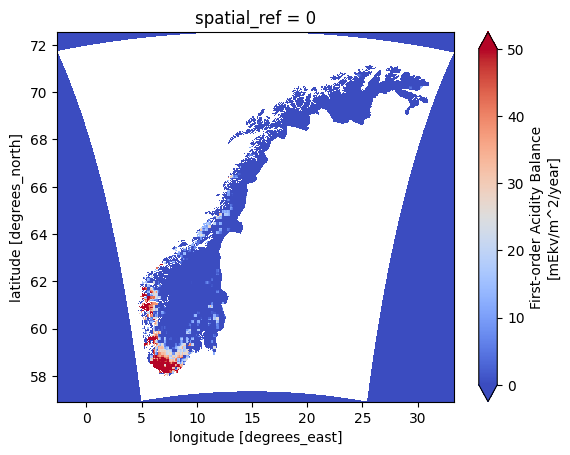

In [6]:
# plotting can be a bit slow
ds.fab.plot(vmin=0, vmax=50, cmap="coolwarm")

In [6]:
get_storage_handler(
    project_name="exceedance-limits",
    dataset_name="fab-sswc-exceed",
    filename_prefix="2012-2016",
    encoding={"spatial_ref": {"dtype": "int16", "scale_factor": 0.1,'_FillValue': -9999}},
).save_dataset(ds)